In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from scipy.interpolate import interp1d
from classy import Class

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.labelsize' : 20})
plt.rcParams.update({'axes.grid' : False})

### Original author for this updated notebook: Jamie Sullivan, github @jmsull

Matter power spectrum:

In [2]:
nuFlag=True
bolt_names = ['h','Omr','Omb','Omcb','ns','Y_p','Neff','smnu','As']

bolt_cosmo = [0.7,5.042e-5,0.046,0.224+0.046,1.0,0.24,3.046,0.06,1e-10*np.exp(3.043)] #this is the choice of Planck TTTEEE in class for nu
cosmo_dict = dict(zip(bolt_names,bolt_cosmo))
# cosmo_dict['Omm'] = cosmo_dict['Omcb']+cosmo_dict['smnu']/93.14/cosmo_dict['h']**2

k = np.logspace(-4,1,2000)

In [3]:
class_ref = {
    'recombination': 'RECFAST',
    'tol_ncdm_bg':1.e-10,
    # 'recfast_Nz0':100000,
    'tol_thermo_integration':1.e-5,
    'recfast_x_He0_trigger_delta':0.01,
    'recfast_x_H0_trigger_delta':0.01,
    'evolver':0,
    'k_min_tau0':0.002,
    'k_max_tau0_over_l_max':3.,
    'k_step_sub':0.015,
    'k_step_super':0.0001,
    'k_step_super_reduction':0.1,
    'start_small_k_at_tau_c_over_tau_h':0.0004,
    'start_large_k_at_tau_h_over_tau_k':0.05,
    'tight_coupling_trigger_tau_c_over_tau_h':0.005,
    'tight_coupling_trigger_tau_c_over_tau_k':0.008,
    'start_sources_at_tau_c_over_tau_h':0.006,
    'l_max_g':50,
    'l_max_pol_g':25,
    'l_max_ur':50,
    'l_max_ncdm':50,
    'tol_perturbations_integration':1.e-6,
    'perturbations_sampling_stepsize':0.01,
    'l_logstep':1.026,
    'l_linstep':25,
    'hyper_sampling_flat':12.,
    'hyper_sampling_curved_low_nu':10.,
    'hyper_sampling_curved_high_nu':10.,
    'hyper_nu_sampling_step':10.,
    'hyper_phi_min_abs':1.e-10,
    'hyper_x_tol':1.e-4,
    'hyper_flat_approximation_nu':1.e6,
    'q_linstep':0.20,
    'q_logstep_spline':20.,
    'q_logstep_trapzd':0.5,
    'q_numstep_transition':250,
    'transfer_neglect_delta_k_S_t0':100.,
    'transfer_neglect_delta_k_S_t1':100.,
    'transfer_neglect_delta_k_S_t2':100.,
    'transfer_neglect_delta_k_S_e':100.,
    'transfer_neglect_delta_k_V_t1':100.,
    'transfer_neglect_delta_k_V_t2':100.,
    'transfer_neglect_delta_k_V_e':100.,
    'transfer_neglect_delta_k_V_b':100.,
    'transfer_neglect_delta_k_T_t2':100.,
    'transfer_neglect_delta_k_T_e':100.,
    'transfer_neglect_delta_k_T_b':100.,
    'neglect_CMB_sources_below_visibility':1.e-30,
    'transfer_neglect_late_source':3000.,
    'halofit_k_per_decade':3000.,
    'l_switch_limber':40.,
    'accurate_lensing':1,
    'num_mu_minus_lmax':1000.,
    'delta_l_max':1000.
}

# additional precision parameters for neutrinos only
class_ref_nu = {
    'radiation_streaming_approximation':2,
    'radiation_streaming_trigger_tau_over_tau_k':240.,
    'radiation_streaming_trigger_tau_c_over_tau':100.,
    'ur_fluid_approximation':2,
    'ur_fluid_trigger_tau_over_tau_k':50.,
    'ncdm_fluid_approximation':3,
    'ncdm_fluid_trigger_tau_over_tau_k':51.,
    'tol_ncdm_synchronous':1.e-10,
    'tol_ncdm_newtonian':1.e-10,
}

In [4]:
def run_camb(cosmo_dict,k,z,nu=False):
    cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_dict['h']*100,
                       ombh2=cosmo_dict['Omb']*cosmo_dict['h']**2,
                       omch2=cosmo_dict['Omcdm']*cosmo_dict['h']**2,
                       mnu=cosmo_dict['smnu'] if nuFlag else 0., 
                       num_massive_neutrinos=1 if nuFlag else 0,

                       YHe=cosmo_dict['Y_p'],
                       omk=0, tau=0.06) #fixed parameters, Planck neutrinos
    pars.set_accuracy(AccuracyBoost=3.0, lAccuracyBoost=3.0, DoLateRadTruncation=False)
    pars.InitPower.set_params(ns=cosmo_dict['ns'],
                              As=cosmo_dict['As'])

    pars.set_matter_power(redshifts=[0.])#, kmax=kmax/h) 
    pars.share_delta_neff = True 

    results = camb.get_results(pars)
    zmin,zmax = 0, 2
    nz=3
    camb_interp = camb.get_matter_power_interpolator(pars,zmin=zmin,zmax=zmax,nz_step=nz,nonlinear=False)
    pinterp = camb_interp.P #defaults #takes (z,k) pairs
    return pinterp(z,k), results

In [5]:
#should really just make a private toolbox with these functions somewhere...
def run_class(cosmo_dict,k,z,nu=False,pk=False,gauge='synchronous'):
    '''Simple call to boltzmann code using input cosmology parameter vector. k in h/Mpc.'''
    #setup
    if('h' not in cosmo_dict.keys()):
        h = cosmo_dict['H0']/100.
    elif('H0' not in cosmo_dict.keys()):
        cosmo_dict['H0'] = cosmo_dict['h']*100.
        h = cosmo_dict['h']
    if('Omcdm' not in cosmo_dict.keys()):
        cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']
        # cosmo_dict['Omcdm'] = cosmo_dict['Omm']-cosmo_dict['Omb']
    c,G = 2.99792e5,4.30071e-9 
    h=cosmo_dict['h']
    if(nu): 
        #use Planck single massive neutrino if using neutrinos
        N_ncdm=1
        m_ncdm=0.06 
    else:
        N_ncdm=0
        m_ncdm=0 
    
    N_ur=3.046-N_ncdm
    # N_ur = 3.046
    print("Nur: {0:.3f}, Nncdm: {1:.3f}, mncdm: {2:.3f}".format(N_ur,N_ncdm,m_ncdm))
    
    ceng = Class()
    #gross but don't want to look up how to do it right now
    if(nuFlag): 
        ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': 2.0308,
              'N_ncdm': N_ncdm,
              'T_ncdm': 0.7133,  # IMPORTANT, see page 11 of arxiv:1104.2935
              'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              'ncdm_fluid_approximation':3,
              'z_reio': 7.6711
              })
    else: ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': N_ur,
#               'N_ncdm': N_ncdm,
#               'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              'ncdm_fluid_approximation':3,
              'z_reio': 7.6711,              
              })
    print(m_ncdm)
    print(ceng.pars)
    #need lower z_max ow issues long complaint, need z<z_rec for pk to work apparently
    ceng.set(class_ref)
    ceng.set(class_ref_nu)
    ceng.set({'output':  'mPk','P_k_max_1/Mpc':10.0})
    ceng.compute()
    plin=[]
    for ki in k: plin.append(ceng.pk(ki*h,z)*h**3) 
    # get P(k) at redshift z=0
    transfers = ceng.get_transfer(z)
    ceng.struct_cleanup()
    ceng.empty()
        
    return transfers,plin,ceng

In [6]:
# bolt_cosmo = [0.7,5.042e-5,0.046,0.224+0.046,1.0,0.24,3.046,1e-10*np.exp(3.043)] #this is the choice of Planck TTTEEE in class for nu
ts0,pL0,ceng = run_class(cosmo_dict,k,np.exp(0)-1,nu=nuFlag,pk=True,gauge='synchronous')

Nur: 2.046, Nncdm: 1.000, mncdm: 0.060
0.06
{'h': 0.7, 'omega_b': 0.022539999999999998, 'omega_cdm': 0.10976, 'n_s': 1.0, 'A_s': 2.096805313253679e-09, 'gauge': 'synchronous', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.06, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711}


In [7]:
ts0,pL0N,ceng = run_class(cosmo_dict,k,np.exp(0)-1,nu=nuFlag,pk=True,gauge='newtonian')

Nur: 2.046, Nncdm: 1.000, mncdm: 0.060
0.06
{'h': 0.7, 'omega_b': 0.022539999999999998, 'omega_cdm': 0.10976, 'n_s': 1.0, 'A_s': 2.096805313253679e-09, 'gauge': 'newtonian', 'N_ur': 2.0308, 'N_ncdm': 1, 'T_ncdm': 0.7133, 'm_ncdm': 0.06, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711}


In [8]:
pCAMB, camb_results = run_camb(cosmo_dict,k,np.exp(0)-1,nu=nuFlag)

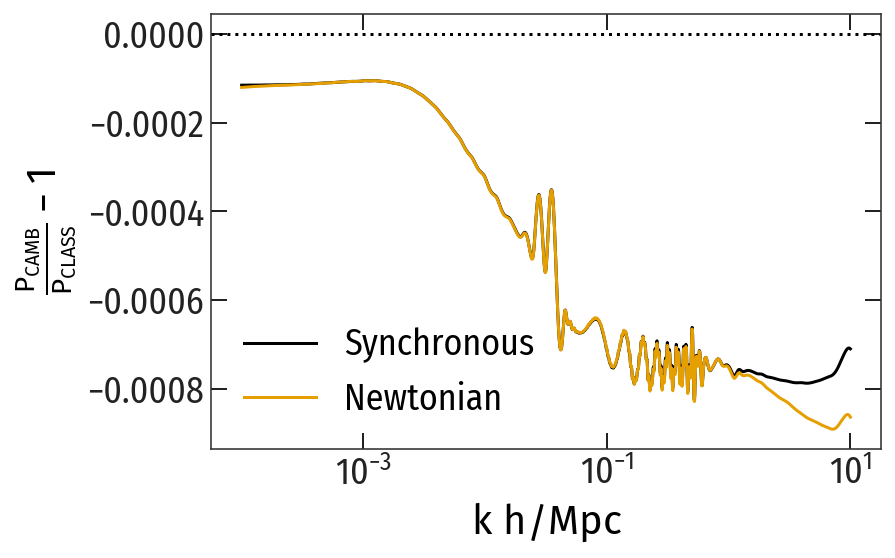

In [9]:
#newtonian vs synch gauge
plt.plot(k,pCAMB/pL0 - 1,label='Synchronous')
plt.plot(k,pCAMB/pL0N - 1 ,label='Newtonian')
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CAMB}}}{P_{\rm{CLASS}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()

In [10]:
nuFlag=False
_,pL0nou,_ = run_class(cosmo_dict,k,np.exp(0)-1,nu=nuFlag,pk=True,gauge='newtonian')
_,pL0nouS,_ = run_class(cosmo_dict,k,np.exp(0)-1,nu=nuFlag,pk=True,gauge='synchronous')
pCAMBnonnu,_ = run_camb(cosmo_dict,k,np.exp(0)-1,nu=nuFlag)

Nur: 3.046, Nncdm: 0.000, mncdm: 0.000
0
{'h': 0.7, 'omega_b': 0.022539999999999998, 'omega_cdm': 0.10976, 'n_s': 1.0, 'A_s': 2.096805313253679e-09, 'gauge': 'newtonian', 'N_ur': 3.046, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711}
Nur: 3.046, Nncdm: 0.000, mncdm: 0.000
0
{'h': 0.7, 'omega_b': 0.022539999999999998, 'omega_cdm': 0.10976, 'n_s': 1.0, 'A_s': 2.096805313253679e-09, 'gauge': 'synchronous', 'N_ur': 3.046, 'YHe': 0.24, 'ncdm_fluid_approximation': 3, 'z_reio': 7.6711}


(0.0031622776601683794, 1)

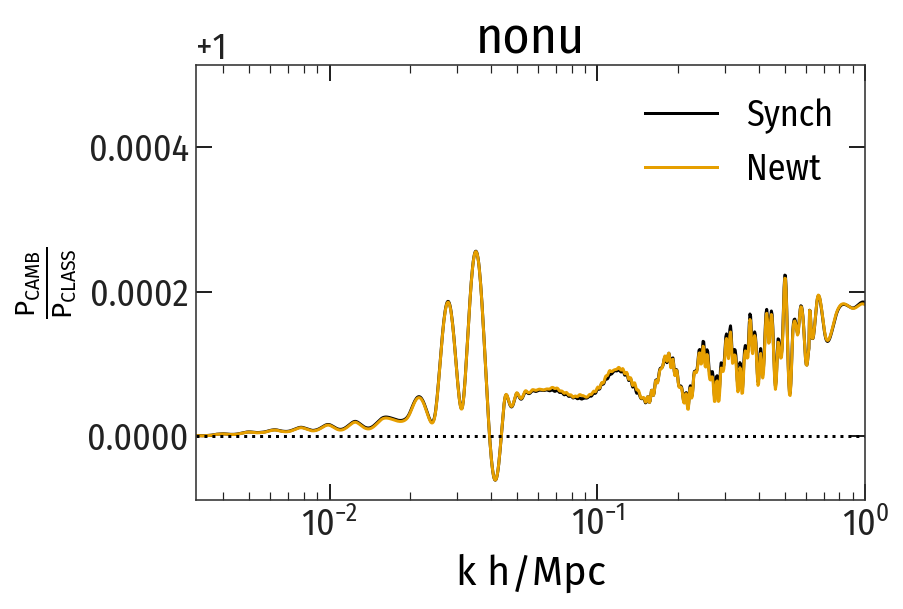

In [12]:
#nonu comparison
plt.title('nonu')
plt.plot(k,pCAMBnonnu/pL0nouS,label='Synch')
plt.plot(k,pCAMBnonnu/pL0nou,label='Newt')
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CAMB}}}{P_{\rm{CLASS}}}$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(1,ls=':',c='k')
plt.legend()
plt.xlim(10**(-2.5),10**0)